# Convolutions

In [102]:
import torch
from torch.utils.data import default_collate
from typing import Mapping

import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl, numpy as np
import pandas as pd,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor, nn

from torch.utils.data import DataLoader
from typing import Mapping

mpl.rcParams['image.cmap'] = 'gray'

In [103]:
# from miniai.training import *
# from miniai.datasets import *

In [104]:
path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])     

# Conv equations

Convs is an inductive bias that allows nns to know smthing about the structure of the problem that makes solve the problem easlyier -> less params required.

Are shift and rotation invariant. 

(torch.Size([28, 28]), <matplotlib.image.AxesImage at 0x2352d9179d0>)

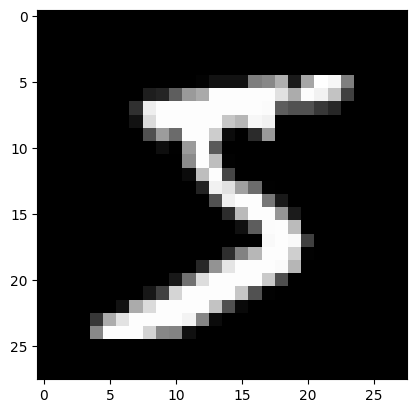

In [105]:
x_img = x_train[0].view(28,28)
x_img.view(28,28).shape, plt.imshow(x_img)


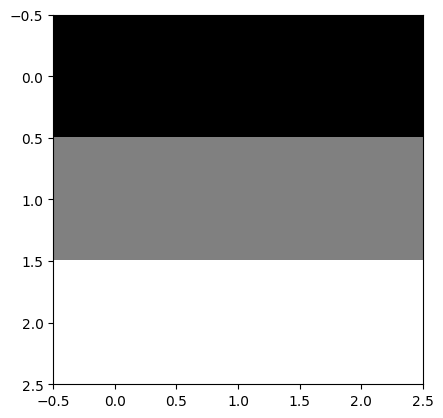

In [106]:
h_edges_kernel = tensor([[-1,-1,-1.],
                         [ 0, 0, 0.],
                         [ 1, 1, 1.],
                        ]).float()

plt.imshow(h_edges_kernel)

In [107]:
df = pd.DataFrame(x_img[:13, :23]) # first 13 rows, and 23 cols indx from 0
# thus 13 and 23 are not included

df.style.format(precision=2).set_properties(**{'font-size':'7pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.07,0.07,0.07,0.49,0.53,0.68,0.10,0.65,1.00,0.96
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12,0.14,0.37,0.60,0.66,0.99,0.99,0.99,0.99,0.99,0.88,0.67,0.99,0.95,0.76
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.19,0.93,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.36,0.32,0.32,0.22,0.15
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.86,0.99,0.99,0.99,0.99,0.99,0.77,0.71,0.96,0.94,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.31,0.61,0.42,0.99,0.99,0.80,0.04,0.00,0.17,0.60,0.00,0.00,0.00,0.00,0.00


so now we slide the kernel over the pic the idea is that when we sllde the kernel over an horizontal edge the out val will be:
- if from white to black -> high positive
- if from black to white -> high negative
- 0 otherwise
 

In [108]:
(x_img[4:7, 11:14] * h_edges_kernel).sum() # top edge
# !maps to scalar!

tensor(2.2539)

In [109]:
(x_img[8:11, 14:17] * h_edges_kernel).sum() # bottom edge

tensor(-2.4492)

In [110]:
# apply the kernel over the whole func

def apply_kernel(row, col, kernel): # r,c is the center of the (3,3)
    return (x_img[row-1:row+2, col-1:col+2]*kernel).sum() 

In [111]:
apply_kernel(5, 12, h_edges_kernel)

tensor(2.2539)

In [112]:
# apply kernel over the whole image. let's start by creating the coords grid for a 5x5
N = 5 
[[(i,j) for j in range(N)] for i in range(N)] # whole pic grid

[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)],
 [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4)]]

In [113]:
# let's try to recreate the same thing for our 28x28
rng = range(1, 27) 
rng[0],rng[-1]

(1, 26)

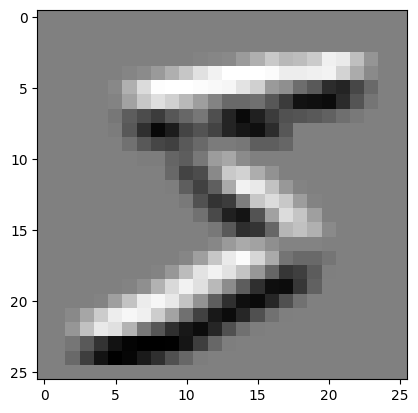

In [114]:
h_edges = tensor([[apply_kernel(i,j, h_edges_kernel) for j in rng] for i in rng])
plt.imshow(h_edges)

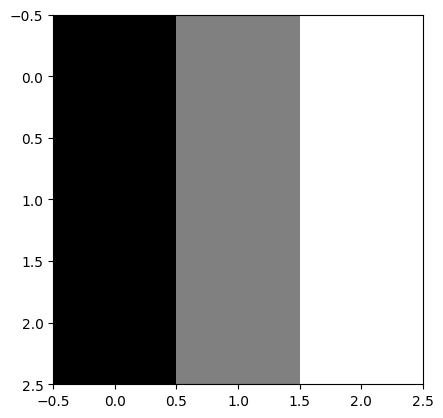

In [115]:
v_edge_kernel =  tensor([[-1, 0, 1.],
                         [-1, 0., 1],
                         [-1, 0., 1],
                        ]).float()
plt.imshow(v_edge_kernel)

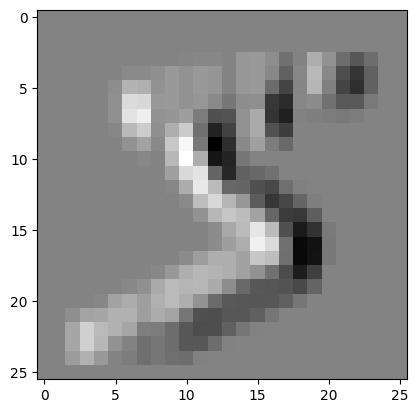

In [116]:
v_edges = tensor([[apply_kernel(i,j, v_edge_kernel) for j in rng] for i in rng])
plt.imshow(v_edges)

# Convolutions in PyTorch

In [117]:
import torch.nn.functional as F
import torch

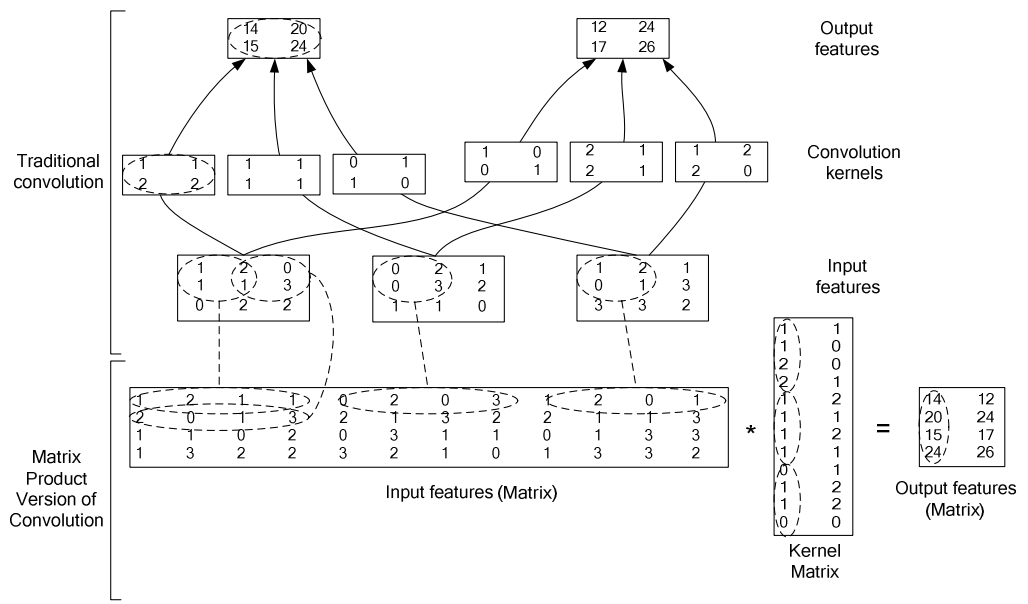

In [118]:
# !dir {os.getcwd() }
from IPython.display import Image
Image(filename="./unfoldConv.png")

In [119]:
# core idea -> convert a convolution in a mat mul (im2col)
# how?
x_img.shape

torch.Size([28, 28])

In [120]:
F.unfold??
# inp requested: 4-D input tensors (batched image-like tensors)

In [121]:
inp = x_img[None, None, :, :]
inp.shape

torch.Size([1, 1, 28, 28])

In [122]:
inp_unfolded = F.unfold(inp, (3, 3))
inp_unfolded.shape

torch.Size([1, 9, 676])

In [123]:
inp_unfolded = inp_unfolded.squeeze()# remove unit axis
inp_unfolded.shape

torch.Size([9, 676])

In [124]:
# create "weight/kernel"
w = v_edge_kernel.view(-1); w # flattened as 

tensor([-1.,  0.,  1., -1.,  0.,  1., -1.,  0.,  1.])

In [125]:
w.shape

torch.Size([9])

In [126]:
out_unf = w@inp_unfolded
out_unf.shape

torch.Size([676])

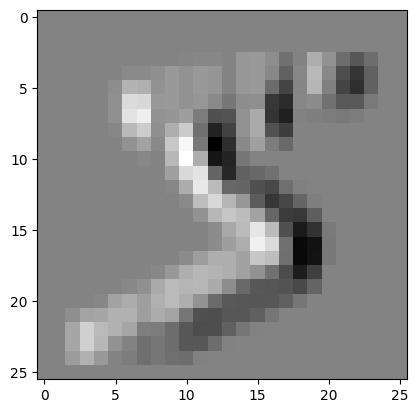

In [127]:
plt.imshow(out_unf.view(26, 26))

## A 2 conv layer example:

In [128]:
# we can now apply conv2d to a whole batch:
xb = x_train[:16].reshape(16,1,28,-1) # I m cheating here using reshape
xb.shape

torch.Size([16, 1, 28, 28])

In [129]:
edge_kernels = torch.stack([h_edges_kernel, v_edge_kernel])
edge_kernels = edge_kernels[:, None, ...]
edge_kernels.shape

torch.Size([2, 1, 3, 3])

In [130]:
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([16, 2, 26, 26])

In [131]:
batch_features[0, 1].shape

torch.Size([26, 26])

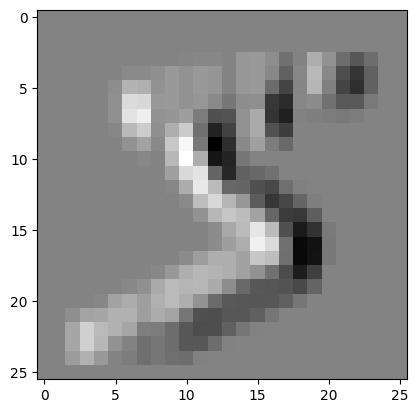

In [132]:
img0 = batch_features[0, 1]
plt.imshow(img0)

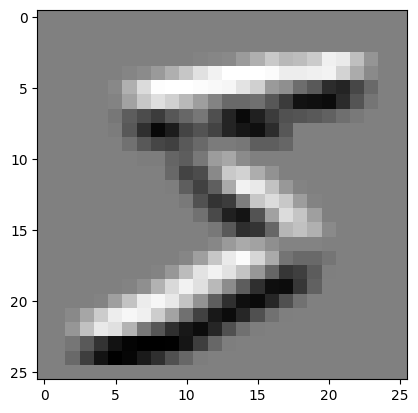

In [133]:
img0 = batch_features[0, 0]
plt.imshow(img0)

# Strides and Padding

Before we were loosing a pixepl on each side bcuz we had to have a 3x3 from img to multiply kernel correctly at edges of img.
To match size we can apply padding.
kernels usually have odd dimensions. Usually padding is used to do not loose info when applying the kernel.
Given a odd kernelSize=ks then to keep the same dim use padding=ks//2

Stride how much we move the kernel over the image
It reduces the dim of input by a factor of 2 (if we use stride=2).

Let's thus now create a CNN.
What is usually done is to apply convs with strides=2 that reduce img untill 
it is a eg 7x7 then you apply max pooling and/or mean pooling out of the 7x7
to map to scalar 

# CNN

In [134]:
n, m = x_train.shape
c = y_train.max()+1
nh = 50

In [135]:
nn.Conv2d?
# Init signature:
# nn.Conv2d(
    # in_channels: int,
    # out_channels: int,
    # kernel_size: int,
    # stride: int, default 1,
    # padding: int, default 0,    
    # bias: bool = True,
    # padding_mode: str = 'zeros',
    # ...
# ) -> None
# Docstring:     
# Applies a 2D convolution over an input signal composed of several input
# planes.

In [136]:
def conv(n_inp, n_out, kernel_size=3, stride=2, act=True):
    res = nn.Conv2d(n_inp, n_out, kernel_size=kernel_size, stride=stride, padding=kernel_size//2)
    if act:
        res = nn.Sequential(res, nn.ReLU())
    return res

In [137]:
# images must have same input
simple_cnn = nn.Sequential(
    conv(1, 4), # from 28x28 to 14x14 cuz of stride=2, 4 channels
    conv(4, 8), # from 14x14 to 7x7 cuz of stride=2, 8 channels
    conv(8, 16), # from 7x7 to 4x4 cuz of stride=2, 16 channels
    conv(16, 16), # from 4x4 to 2x2 cuz of stride=2, 16 channels
    conv(16, 10, act=False), # from 2x2 to 1x1, a scalar without activation
    # cuz now we apply F.cross_entropy, 10 channels, one for each class
    nn.Flatten(), #removes unit axes
)
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [37]:
simple_cnn(xb).shape

torch.Size([16, 10])

In [38]:
x_train.shape
# we need [bs, channels, h, w]

torch.Size([50000, 784])

In [39]:
x_imgs = x_train.view(-1, 1, 28, 28)
xvalid_imgs = x_valid.view(-1, 1, 28, 28)

In [40]:
# EXPORT
class Dataset():
    def __init__(self, x, y):
        self.x, self.y = x, y
        
    def __len__(self): 
        return len(self.x)
    
    def __getitem__(self, i): # overloader for the [] operator
        # this method could have a lot of logic, so usually is parallelized
        # to pre-process batchSize obs that have to be returned 
        # recall that this method can be called with slicing
        return self.x[i], self.y[i]
    
from torch.utils.data import DataLoader
def get_dataLoaders(train_ds, valid_ds, bs, **kwards):        
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwards), DataLoader(valid_ds, batch_size=bs*2, **kwards))
# you can double bs for validation data loader cuz it wont have to do backprop and thus half mem

def accuracy(out, y):
    return (out.argmax(dim=1) == y).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc, count = 0.,0.,0
            for xb, yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred, yb).item()*n
                tot_acc += accuracy(pred, yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [41]:
train_ds, valid_ds = Dataset(x_imgs, y_train), Dataset(xvalid_imgs, y_valid)

In [42]:
# export
device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=device): # to review
    if isinstance(x, Mapping):
        return {k:v.to(device) for k,v in x.items()}
    return type(x)(o.to(device) for o in x)    

In [43]:
from torch.utils.data import default_collate
def collate_device(b):
    return to_device(default_collate(b))

In [44]:
bs = 64
lr =0.4
train_dl, valid_dl = get_dataLoaders(train_ds, valid_ds, bs, collate_fn=collate_device)
    
from torch import optim
opt = optim.SGD(simple_cnn.parameters(), lr=lr)

In [45]:
loss, acc = fit(5, simple_cnn.to(device), F.cross_entropy, opt, train_dl, valid_dl) 

0 0.17722799953222274 0.9456
1 0.11419766327738762 0.9667
2 0.1826867634296417 0.9408
3 0.0881016023606062 0.9749
4 0.11385850793719292 0.9666


In [46]:
# a very cool thing about cnn wrt mlp:
mlp_model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, 10))

def count_params(model):
    return sum(o.numel() for o in model.parameters())

count_params(mlp_model), count_params(simple_cnn) # down by a factor of 7.5!
# https://stackoverflow.com/questions/42786717/how-to-calculate-the-number-of-parameters-for-convolutional-neural-network

(39760, 5274)

In [47]:
# Test on numbers
x1 = x_train[0].view(1,1,28, 28)
x1.shape

x11 = torch.stack([x1,x1],dim=2)[0]
x11.shape

torch.Size([1, 2, 28, 28])

In [48]:
edge_kernels = torch.stack([h_edges_kernel, v_edge_kernel])
edge_kernels = edge_kernels[:, None, ...]
edge_kernels.shape

torch.Size([2, 1, 3, 3])

In [49]:
w = torch.stack([edge_kernels, edge_kernels], dim = 1)
w.squeeze_()
w.shape

torch.Size([2, 2, 3, 3])

In [50]:
batch_features = F.conv2d(x11, w)
batch_features.shape

torch.Size([1, 2, 26, 26])

# Convolution Layer Details: 

- input dims: [bs, cIn, w, h] 
- filters dims: [nf, cOut, fw, fh] 

Apply conv: input * filters = out
- out dims: [bs, cOut, w', h'] 

In each conv layer for each input we have cIn channels ==>> #cIn images for each obs.
In each conv layer are learnt:
	#cIn_channels x #cOut_channels = #unique kernels

Which means that each for input channel we have #cOut different kernels. 
These kernel are different over each channel, but are shared among observations.

So we have a fixed set of kernels for each input channel:

kernelMappings = dict({ # think this as a 2d matrix (but it is a 4d tensor) \
	"input_channel_1": (k_1, k_2, ..., k_cOut), \
	"input_channel_2": (k'_1, k'_2, ..., k'_cOut), \
		... \
	"input_channel_cIn": (k''_1, k''_2, ..., k''_cOut}) \
}) # for each input channel we have cOut kernels, all different across all input channels \

output = [] \
for each img in batch: \
	> tmp_out = [] \
	> for i in range(cOut):	 \
	>>	res = empty_img \
	>>	for j in range(cIn):\
	>>>		img = conv(input_channel_j_img, kernelMappings["input_channel_j"][i])\
	>>>		res += img \
	>>	tmp_out.append(res) \
	>output.append(tmp_out) \


out dims: [bs, cOut, img_w, img_h] 


- What does this imply? 
- confirm shapes: weight = torch.randn(out_channels, in_channels, ks, ks)


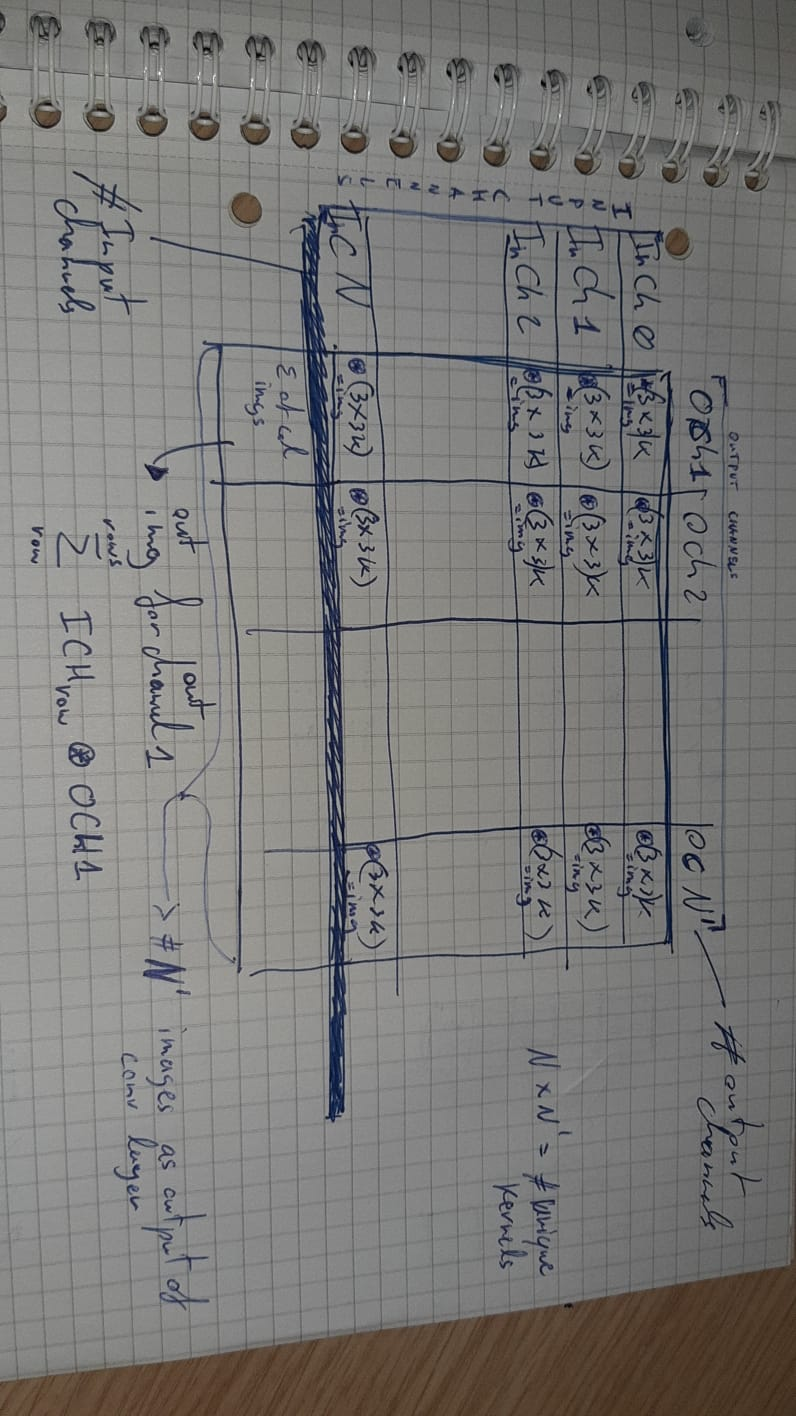

In [142]:
Image(filename="./convSumFilters.jpg")

! The same set of filters is applied to every image in the batch

# AutoEncoders

In [52]:
# EXPORT
def inplace(f): # so we have the inplace func transformInplace passed as in
    def _f(b): # create a new func
        f(b) # that applies the input func (transformInplace) that acts on its input
        return b # return the new input
    return _f # return the function that modifies b inplace

from operator import itemgetter
# we can use this default collate to collate a dict such to make it as tuple
def collate_dict(ds): # transform hugging face stuff that is in dict to tuples
    get = itemgetter(*ds.features) # a func that gets items from dict wrt inputs
    def _f(b): # take a batch
        return get(default_collate(b)) # from batch collate  ['image', 'label'] 
    return _f

In [53]:
from datasets import load_dataset
name = 'fashion_mnist'
dsd = load_dataset(name)

In [54]:
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [55]:
dsd['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [56]:
x, y = 'image', 'label'

In [66]:
import torchvision.transforms.functional as TF

@inplace
def transform_(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]

In [67]:
bs = 64
tds = dsd.with_transform(transform_)
ds = tds['train']
cf = collate_dict(ds)

In [68]:
def collate_(b):
    return to_device(cf(b))

In [69]:
def data_loaders(dsd, bs, **kwargs):
    return ({k:DataLoader(v, bs, **kwargs) for k,v in dsd.items()})

In [73]:
tds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [70]:
dls = data_loaders(tds, bs, collate_fn=collate_)
# tds has inplace transform to cast from PIL to tensor
# collate_ has splits xs, ys and sends 'em to device

In [77]:
dt = dls['train']
dv = dls['test']

xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

Let's start by training our cnn for classification on this dataset

In [82]:
simple_cnn = nn.Sequential(
    conv(1, 4), # from 28x28 to 14x14 cuz of stride=2, 4 channels
    conv(4, 8), # from 14x14 to 7x7 cuz of stride=2, 8 channels
    conv(8, 16), # from 7x7 to 4x4 cuz of stride=2, 16 channels
    conv(16, 16), # from 4x4 to 2x2 cuz of stride=2, 16 channels
    conv(16, 10, act=False), # from 2x2 to 1x1, a scalar without activation
    # cuz now we apply F.cross_entropy, 10 channels, one for each class
    nn.Flatten(), #removes unit axes
)
simple_cnn

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [83]:
lr = 0.4
opt = optim.SGD(simple_cnn.parameters(), lr=lr)
loss, acc = fit(5, simple_cnn.to(device), F.cross_entropy, opt, dt, dv)

KeyboardInterrupt: 

Very slow. Tweaks:
1) increase n_workers in data_loaders/DataLoader.
    Important: you cant make multiple workers send data to gpu
2) Bad predictions

# AutoEncoder

Upscaling options: 
1) transpose conv
2) stride 1/2
3) nearest neighbour + conv2d with stride1 for upsampling <- what we use here

In [88]:
def deconv(ni, nf, ks=3, act=True):
    layers = [nn.UpsamplingNearest2d(scale_factor=2),
              nn.Conv2d(ni, nf, stride=1, kernel_size=ks, padding=ks//2)
             ]
    if act:
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [89]:
def eval(model, loss_func, valid_dl, epoch=0):
    model.eval()
    with torch.no_grad():
        tot_loss, count = 0.,0
        for xb, _ in valid_dl: # autoencoders do not need y
            pred = model(xb)
            n = len(xb)
            count += n
            tot_loss += loss_func(pred, xb).item()*n            
    print(epoch, tot_loss/count)

In [96]:
# split eval method from fit function cuz evaluation for 
# ae is different from classification!

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, _ in train_dl:
            loss = loss_func(model(xb), xb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        eval(model, loss_func, valid_dl, epoch=epoch)

In [97]:
# we add 2 pixels on each side s.t. we can apply 3 convs 
# and obtain integer dimensions at end of third conv layer
ae = nn.Sequential(
    nn.ZeroPad2d(2), # add 2 pixels on each side
    conv(1,2),
    conv(2,4),
    conv(4,8),
    deconv(8, 4),
    deconv(4, 2),
    deconv(2, 1, act=False),
    nn.ZeroPad2d(-2),
    nn.Sigmoid()  # forces to 0,1 since grayscale  
).to(device)

In [98]:
eval(ae, F.mse_loss, dv)

0 0.16640948712825776


In [99]:
opt = optim.SGD(ae.parameters(), lr=0.01)
fit(5, ae, F.mse_loss, opt, dt, dv)

0 0.12897748250961305


KeyboardInterrupt: 

here show real vs recreated
results are not great -> we must experiment -> we need to iterate/experiment many
times, we need a framework to avoid doing things manually like above! 
(as I have always done)  